# LGBM

## 라이브러리 import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import glob
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import ast

import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

In [3]:
# seed 고정
SD = 42
random.seed(SD)
np.random.seed(SD)
os.environ['PYTHONHASHSEED'] = str(SD)

## Data Processing

### 데이터 로드

In [4]:
# 파일 경로 설정
data_dir = '/content/drive/MyDrive/ETRI/ch2025_data_items'

# Parzquet 파일 전체 경로 리스트
parquet_files = glob.glob(os.path.join(data_dir, 'ch2025_*.parquet'))

In [5]:
# 파일 이름을 키로, DataFrame을 값으로 저장할 딕셔너리
lifelog_data = {}

# 파일별로 읽기
for file_path in parquet_files:
    name = os.path.basename(file_path).replace('.parquet', '').replace('ch2025_', '')
    lifelog_data[name] = pd.read_parquet(file_path)
    print(f"✅ Loaded: {name}, shape = {lifelog_data[name].shape}")

✅ Loaded: mACStatus, shape = (939896, 3)
✅ Loaded: mActivity, shape = (961062, 3)
✅ Loaded: mAmbience, shape = (476577, 3)
✅ Loaded: mBle, shape = (21830, 3)
✅ Loaded: mGps, shape = (800611, 3)
✅ Loaded: mLight, shape = (96258, 3)
✅ Loaded: mScreenStatus, shape = (939653, 3)
✅ Loaded: mUsageStats, shape = (45197, 3)
✅ Loaded: mWifi, shape = (76336, 3)
✅ Loaded: wHr, shape = (382918, 3)
✅ Loaded: wLight, shape = (633741, 3)
✅ Loaded: wPedo, shape = (748100, 9)
✅ Loaded: features, shape = (450, 29)


In [6]:
# 딕셔너리에 있는 모든 항목을 독립적인 변수로 할당
for key, df in lifelog_data.items():
    globals()[f"{key}_df"] = df

In [7]:
# lifelog_date가 timestamp랑 같다
metrics_train = pd.read_csv('/content/drive/MyDrive/ETRI/ch2025_metrics_train.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/ETRI/ch2025_submission_sample.csv')

In [8]:
# ✅ 기준 쌍 (subject_id, lifelog_date)
sample_submission['lifelog_date'] = pd.to_datetime(sample_submission['lifelog_date'])
test_keys = set(zip(sample_submission['subject_id'], sample_submission['lifelog_date'].dt.date))

# ✅ DataFrame 별 timestamp 컬럼 수동 지정
dataframes = {
    'mACStatus': (mACStatus_df, 'timestamp'),
    'mActivity': (mActivity_df, 'timestamp'),
    'mAmbience': (mAmbience_df, 'timestamp'),
    'mBle': (mBle_df, 'timestamp'),
    'mGps': (mGps_df, 'timestamp'),
    'mLight': (mLight_df, 'timestamp'),
    'mScreenStatus': (mScreenStatus_df, 'timestamp'),
    'mUsageStats': (mUsageStats_df, 'timestamp'),
    'mWifi': (mWifi_df, 'timestamp'),
    'wHr': (wHr_df, 'timestamp'),
    'wLight': (wLight_df, 'timestamp'),
    'wPedo': (wPedo_df, 'timestamp'),
}

# ✅ 분리 함수
def split_test_train(df, subject_col='subject_id', timestamp_col='timestamp'):
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce')
    df = df.dropna(subset=[timestamp_col])
    df['date_only'] = df[timestamp_col].dt.date
    df['key'] = list(zip(df[subject_col], df['date_only']))

    test_df = df[df['key'].isin(test_keys)].drop(columns=['date_only', 'key'])
    train_df = df[~df['key'].isin(test_keys)].drop(columns=['date_only', 'key'])
    return test_df, train_df

# ✅ 결과 저장
for name, (df, ts_col) in dataframes.items():
    print(f"⏳ {name} 분리 중...")
    test_df, train_df = split_test_train(df.copy(), subject_col='subject_id', timestamp_col=ts_col)
    globals()[f"{name}_test"] = test_df
    globals()[f"{name}_train"] = train_df
    print(f"✅ {name}_test → {test_df.shape}, {name}_train → {train_df.shape}")

⏳ mACStatus 분리 중...
✅ mACStatus_test → (335849, 3), mACStatus_train → (604047, 3)
⏳ mActivity 분리 중...
✅ mActivity_test → (343579, 3), mActivity_train → (617483, 3)
⏳ mAmbience 분리 중...
✅ mAmbience_test → (170453, 3), mAmbience_train → (306124, 3)
⏳ mBle 분리 중...
✅ mBle_test → (8140, 3), mBle_train → (13690, 3)
⏳ mGps 분리 중...
✅ mGps_test → (287386, 3), mGps_train → (513225, 3)
⏳ mLight 분리 중...
✅ mLight_test → (34439, 3), mLight_train → (61819, 3)
⏳ mScreenStatus 분리 중...
✅ mScreenStatus_test → (336160, 3), mScreenStatus_train → (603493, 3)
⏳ mUsageStats 분리 중...
✅ mUsageStats_test → (16499, 3), mUsageStats_train → (28698, 3)
⏳ mWifi 분리 중...
✅ mWifi_test → (27467, 3), mWifi_train → (48869, 3)
⏳ wHr 분리 중...
✅ wHr_test → (143311, 3), wHr_train → (239607, 3)
⏳ wLight 분리 중...
✅ wLight_test → (233809, 3), wLight_train → (399932, 3)
⏳ wPedo 분리 중...
✅ wPedo_test → (288832, 9), wPedo_train → (459268, 9)


### 분단위 -> 하루 단위 def

In [9]:
# def process_mACStatus(df):
#     df['timestamp'] = pd.to_datetime(df['timestamp'])
#     df['date'] = df['timestamp'].dt.date
#     df = df.sort_values(['subject_id', 'timestamp'])

#     results = []

#     for (subj, date), group in df.groupby(['subject_id', 'date']):
#         status = group['m_charging'].values  # 0/1 상태
#         times = group['timestamp'].values

#         # 충전 상태 비율
#         ratio_charging = status.mean()

#         # 상태 전이 횟수
#         transitions = (status[1:] != status[:-1]).sum()

#         # 연속된 1 상태 길이들
#         lengths = []
#         current_len = 0
#         for val in status:
#             if val == 1:
#                 current_len += 1
#             elif current_len > 0:
#                 lengths.append(current_len)
#                 current_len = 0
#         if current_len > 0:
#             lengths.append(current_len)

#         avg_charging_duration = np.mean(lengths) if lengths else 0
#         max_charging_duration = np.max(lengths) if lengths else 0

#         results.append({
#             'subject_id': subj,
#             'date': date,
#             'charging_ratio': ratio_charging,
#             'charging_transitions': transitions,
#             'avg_charging_duration': avg_charging_duration,
#             'max_charging_duration': max_charging_duration,
#         })

#     return pd.DataFrame(results)

# mACStatus_df2 = process_mACStatus(mACStatus_df)

In [10]:
import numpy as np
import pandas as pd

def process_mACStatus(df):
    # 1) timestamp→datetime, date 컬럼 생성, 정렬
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df = df.sort_values(['subject_id','timestamp'])

    output = []
    for (subj, date), group in df.groupby(['subject_id','date']):
        status = group['m_charging'].values
        # pandas Timestamp → Python datetime 으로 변환
        times  = group['timestamp'].dt.to_pydatetime().tolist()

        # a) 충전 비율 & 전이 횟수
        ratio     = status.mean()
        transitions = (status[1:] != status[:-1]).sum()

        # b) 충전 세션(start→end) 추출
        sessions = []
        in_session = False
        for i, val in enumerate(status):
            if val == 1 and not in_session:
                start_time = times[i]
                in_session = True
            elif val == 0 and in_session:
                end_time = times[i]
                sessions.append((start_time, end_time))
                in_session = False
        # 마지막에 세션이 끝나지 않았다면
        if in_session:
            sessions.append((start_time, times[-1]))

        # c) 세션별 지속시간(초) 계산
        durations = [ (end-start).total_seconds() for start,end in sessions ]
        avg_dur_s = np.mean(durations) if durations else 0
        max_dur_s = np.max(durations) if durations else 0

        # d) 세션 시작 시각(시간 단위, e.g. 14.5 = 14시30분)
        start_hours = [ t.hour + t.minute/60.0 for t,_ in sessions ]
        mean_start   = np.mean(start_hours) if start_hours else np.nan
        std_start    = np.std(start_hours)  if start_hours else np.nan

        # e) 세션 개수
        session_count = len(sessions)

        output.append({
            'subject_id':              subj,
            'date':                    date,
            'charging_ratio':          ratio,
            'charging_transitions':    transitions,
            'charging_session_count':  session_count,
            'avg_charging_duration_s': avg_dur_s,
            'max_charging_duration_s': max_dur_s,
            'mean_charging_start_hour':mean_start,
            'std_charging_start_hour': std_start,
        })

    return pd.DataFrame(output)

# 적용 예시
mACStatus_df2 = process_mACStatus(mACStatus_df)


In [11]:
def process_mActivity(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    summary = []

    for (subj, date), group in df.groupby(['subject_id', 'date']):
        counts = group['m_activity'].value_counts(normalize=True)  # 비율
        row = {'subject_id': subj, 'date': date}

        # 0~8 비율 저장
        for i in range(9):
            row[f'activity_{i}_ratio'] = counts.get(i, 0)

        # 주요 활동 정보
        row['dominant_activity'] = group['m_activity'].mode()[0]
        row['num_unique_activities'] = group['m_activity'].nunique()

        summary.append(row)

    return pd.DataFrame(summary)

mActivity_df2 = process_mActivity(mActivity_df)

In [12]:
# import numpy as np
# import pandas as pd
# from scipy.stats import entropy

# # 1) 시간대 블록화 헬퍼 함수
# def get_time_block(hour: int) -> str:
#     if 0 <= hour < 6:
#         return 'early_morning'
#     elif 6 <= hour < 12:
#         return 'morning'
#     elif 12 <= hour < 18:
#         return 'afternoon'
#     else:
#         return 'evening'

# def process_mActivity(df):
#     df = df.copy()
#     df['timestamp'] = pd.to_datetime(df['timestamp'])
#     df['date']      = df['timestamp'].dt.date

#     records = []
#     for (subj,date), grp in df.groupby(['subject_id','date']):
#         arr = grp['m_activity'].values
#         counts = grp['m_activity'].value_counts(normalize=True)
#         row = {
#             'subject_id': subj,
#             'date':       date
#         }
#         # 기본 분포
#         for i in range(9):
#             row[f'activity_{i}_ratio'] = counts.get(i,0.0)
#         row['dominant_activity']     = grp['m_activity'].mode().iloc[0]
#         row['num_unique_activities'] = grp['m_activity'].nunique()
#         # 런 길이 통계
#         lengths = []
#         cur = 1
#         for k in range(1,len(arr)):
#             if arr[k]==arr[k-1]: cur+=1
#             else:
#                 lengths.append(cur)
#                 cur=1
#         lengths.append(cur)
#         row['avg_activity_run_length'] = np.mean(lengths)
#         row['max_activity_run_length'] = np.max(lengths)

#         records.append(row)
#     return pd.DataFrame(records)

# # 사용 예시
# mActivity_df2 = process_mActivity(mActivity_df)


In [13]:
# from sklearn.model_selection import GroupKFold
# from sklearn.metrics import f1_score
# import numpy as np
# from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# # 파라미터 조정
# tuned_params = {
#     'n_estimators': 2000,
#     'learning_rate': 0.1,
#     'num_leaves': 64,
#     'max_depth': 10,
#     'min_data_in_leaf': 20,
#     'feature_fraction': 1.0,
#     'bagging_fraction': 1.0,
#     'bagging_freq': 0,
#     'lambda_l1': 0.0,
#     'lambda_l2': 0.0,
#     'objective': 'multiclass',
#     'num_class': y.nunique(),
#     'random_state': SD,
#     'verbosity': -1,
#     'metric': 'multi_logloss'
# }

# gkf = GroupKFold(n_splits=5)
# train_scores, val_scores = [], []

# for fold, (tr_idx, val_idx) in enumerate(
#         gkf.split(X, y, groups=train_df['subject_id']), 1):
#     X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
#     y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

#     model = LGBMClassifier(**tuned_params)
#     model.fit(
#         X_tr, y_tr,
#         eval_set=[(X_val, y_val)],
#         eval_metric='multi_logloss',
#         callbacks=[early_stopping(stopping_rounds=100), log_evaluation(period=0)]
#     )

#     y_tr_pred  = model.predict(X_tr)
#     y_val_pred = model.predict(X_val)
#     train_scores.append(f1_score(y_tr, y_tr_pred, average='macro'))
#     val_scores.append(f1_score(y_val, y_val_pred, average='macro'))
#     print(f"Fold {fold} — Train F1: {train_scores[-1]:.4f}, Val F1: {val_scores[-1]:.4f}")

# print(f"\nTrain F1: {np.mean(train_scores):.4f} ± {np.std(train_scores):.4f}")
# print(f" Val  F1: {np.mean(val_scores):.4f} ± {np.std(val_scores):.4f}")


In [14]:
# from sklearn.model_selection import GroupKFold
# from sklearn.metrics import f1_score
# import numpy as np
# from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# # 0) 공통 준비
# groups = train_df['subject_id']
# gkf = GroupKFold(n_splits=5)

# # 1) 피처군 별 컬럼 리스트
# base_cols = [f'activity_{i}_ratio' for i in range(9)] + [
#     'dominant_activity', 'num_unique_activities'
# ]
# trans_cols     = ['activity_transitions']
# run_cols       = ['avg_activity_run_length','max_activity_run_length']
# entropy_cols   = ['activity_entropy']
# timeblock_cols = [
#     'early_morning_ratio',
#     'morning_ratio',
#     'afternoon_ratio',
#     'evening_ratio'
# ]

# groups_of_features = {
#     'base':      base_cols,
#     '＋trans':   trans_cols,
#     '＋run':     run_cols,
#     '＋entropy': entropy_cols,
#     '＋time':    timeblock_cols,
# }

# def cv_score(feature_sets):
#     cols = sum(feature_sets, [])  # 리스트 합치기
#     X_sub = X[cols]
#     tr, va = [], []
#     for tr_idx, val_idx in gkf.split(X_sub, y, groups=groups):
#         X_tr, X_val = X_sub.iloc[tr_idx], X_sub.iloc[val_idx]
#         y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
#         model = LGBMClassifier(**tuned_params)
#         model.fit(
#             X_tr, y_tr,
#             eval_set=[(X_val, y_val)],
#             callbacks=[early_stopping(stopping_rounds=100), log_evaluation(period=0)]
#         )
#         tr.append(f1_score(y_tr, model.predict(X_tr), average='macro'))
#         va.append(f1_score(y_val, model.predict(X_val), average='macro'))
#     return np.mean(tr), np.std(tr), np.mean(va), np.std(va)

# # 2) 단계별 추가
# results = {}
# order = ['base','＋trans','＋run','＋entropy','＋time']
# current = ['base']
# for name in order:
#     if name != 'base':
#         current.append(name)
#     feature_sets = [groups_of_features[k] for k in current]
#     tr_mean, tr_std, va_mean, va_std = cv_score(feature_sets)
#     results[' & '.join(current)] = (tr_mean, tr_std, va_mean, va_std)

# for k,(tms,ts,vms,vs) in results.items():
#     print(f"{k:20s} — Train F1 {tms:.3f}±{ts:.3f}, Val F1 {vms:.3f}±{vs:.3f}")


In [15]:
# 지정된 10개 라벨
top_10_labels = [
    "Inside, small room", "Speech", "Silence", "Music",
    "Narration, monologue", "Child speech, kid speaking",
    "Conversation", "Speech synthesizer", "Shout", "Babbling"
]

def process_mAmbience_top10(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    # 초기화
    for label in top_10_labels + ['others']:
        df[label] = 0.0

    for idx, row in df.iterrows():
        parsed = ast.literal_eval(row['m_ambience']) if isinstance(row['m_ambience'], str) else row['m_ambience']
        others_prob = 0.0

        for label, prob in parsed:
            prob = float(prob)
            if label in top_10_labels:
                df.at[idx, label] = prob
            else:
                others_prob += prob

        df.at[idx, 'others'] = others_prob

    return df.drop(columns=['m_ambience'])

mAmbience_df2= process_mAmbience_top10(mAmbience_df)

def summarize_mAmbience_daily(df):
    prob_cols = [col for col in df.columns if col not in ['subject_id', 'timestamp', 'date']]

    # 하루 단위로 평균값 요약
    daily_summary = df.groupby(['subject_id', 'date'])[prob_cols].mean().reset_index()
    return daily_summary

mAmbience_df2 = summarize_mAmbience_daily(mAmbience_df2)

In [16]:
# import numpy as np
# import pandas as pd
# from scipy.stats import entropy

# # 재사용: 시간대 블록화 헬퍼
# def get_time_block(hour: int) -> str:
#     if 0 <= hour < 6:
#         return 'early_morning'
#     elif 6 <= hour < 12:
#         return 'morning'
#     elif 12 <= hour < 18:
#         return 'afternoon'
#     else:
#         return 'evening'

# def process_mAmbience(df: pd.DataFrame, top_n: int = 10) -> pd.DataFrame:
#     """
#     mAmbience 원시 로그(df)에 대해 다음 피처를 추출합니다:
#       1. ambience_top{N}_entropy: 상위 N개 소리 라벨 분포의 엔트로피(base-2)
#       2. {early_morning, morning, afternoon, evening}_ambience_dom_ratio:
#          각 시간대별 대표(최빈) 소리 라벨의 비율
#     """
#     df = df.copy()
#     df['timestamp']  = pd.to_datetime(df['timestamp'])
#     df['date']       = df['timestamp'].dt.date
#     df['time_block'] = df['timestamp'].dt.hour.map(get_time_block)

#     records = []
#     for (subj, date), group in df.groupby(['subject_id', 'date']):
#         row = {'subject_id': subj, 'date': date}

#         # 1) 상위 N개 라벨의 분포 엔트로피
#         counts = group['m_ambience'].value_counts(normalize=True)
#         top_counts = counts.iloc[:top_n].values
#         # 만약 N개 미만 라벨이 존재하면 전체 라벨 분포로 대체
#         if len(top_counts) < top_n:
#             top_counts = counts.values
#         row[f'ambience_top{top_n}_entropy'] = float(entropy(top_counts, base=2))

#         # 2) 시간대별 대표 소리 라벨 비율
#         for blk in ['early_morning', 'morning', 'afternoon', 'evening']:
#             sub_blk = group[group['time_block'] == blk]['m_ambience']
#             if sub_blk.empty:
#                 dom_ratio = 0.0
#             else:
#                 c = sub_blk.value_counts(normalize=True)
#                 dom_ratio = float(c.iloc[0])
#             row[f'{blk}_ambience_dom_ratio'] = dom_ratio

#         records.append(row)

#     return pd.DataFrame(records)

# # 적용 예시
# mAmbience_df2 = process_mAmbience(mAmbience_df, top_n=10)


In [17]:
def process_mBle(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    features = []

    for idx, row in df.iterrows():
        entry = ast.literal_eval(row['m_ble']) if isinstance(row['m_ble'], str) else row['m_ble']

        rssi_list = []
        class_0_cnt = 0
        class_other_cnt = 0

        for device in entry:
            try:
                rssi = int(device['rssi'])
                rssi_list.append(rssi)

                if str(device['device_class']) == '0':
                    class_0_cnt += 1
                else:
                    class_other_cnt += 1
            except:
                continue  # malformed record

        feature = {
            'subject_id': row['subject_id'],
            'date': row['date'],
            'device_class_0_cnt': class_0_cnt,
            'device_class_others_cnt': class_other_cnt,
            'device_count': len(rssi_list),
            'rssi_mean': np.mean(rssi_list) if rssi_list else np.nan,
            'rssi_min': np.min(rssi_list) if rssi_list else np.nan,
            'rssi_max': np.max(rssi_list) if rssi_list else np.nan,
        }
        features.append(feature)

    return pd.DataFrame(features)

def summarize_mBle_daily(df):
    # row 단위 BLE feature 추출
    df = process_mBle(df)

    # 하루 단위로 cnt 합치기
    grouped = df.groupby(['subject_id', 'date']).agg({
        'device_class_0_cnt': 'sum',
        'device_class_others_cnt': 'sum',
        'rssi_mean': 'mean',
        'rssi_min': 'min',
        'rssi_max': 'max',
    }).reset_index()

    # 총합 구해서 비율 계산
    total_cnt = grouped['device_class_0_cnt'] + grouped['device_class_others_cnt']
    grouped['device_class_0_ratio'] = grouped['device_class_0_cnt'] / total_cnt.replace(0, np.nan)
    grouped['device_class_others_ratio'] = grouped['device_class_others_cnt'] / total_cnt.replace(0, np.nan)

    # 필요 없는 원래 cnt 컬럼 제거
    grouped.drop(columns=['device_class_0_cnt', 'device_class_others_cnt'], inplace=True)

    return grouped

mBle_df2 = summarize_mBle_daily(mBle_df)

In [18]:
def process_mGps(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    features = []

    for idx, row in df.iterrows():
        gps_list = ast.literal_eval(row['m_gps']) if isinstance(row['m_gps'], str) else row['m_gps']

        altitudes = []
        latitudes = []
        longitudes = []
        speeds = []

        for entry in gps_list:
            try:
                altitudes.append(float(entry['altitude']))
                latitudes.append(float(entry['latitude']))
                longitudes.append(float(entry['longitude']))
                speeds.append(float(entry['speed']))
            except:
                continue

        features.append({
            'subject_id': row['subject_id'],
            'date': row['date'],
            'altitude_mean': np.mean(altitudes) if altitudes else np.nan,
            'latitude_std': np.std(latitudes) if latitudes else np.nan,
            'longitude_std': np.std(longitudes) if longitudes else np.nan,
            'speed_mean': np.mean(speeds) if speeds else np.nan,
            'speed_max': np.max(speeds) if speeds else np.nan,
            'speed_std': np.std(speeds) if speeds else np.nan,
        })

    return pd.DataFrame(features)

m_Gps_df2 = process_mGps(mGps_df)

m_Gps_df2 = m_Gps_df2.groupby(['subject_id', 'date']).agg({
    'altitude_mean': 'mean',
    'latitude_std': 'mean',
    'longitude_std': 'mean',
    'speed_mean': 'mean',
    'speed_max': 'max',
    'speed_std': 'mean'
}).reset_index()

In [19]:
def process_mLight(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['hour'] = df['timestamp'].dt.hour

    # 밤(22~05시), 낮(06~21시) 구분
    df['is_night'] = df['hour'].apply(lambda h: h >= 22 or h < 6)

    # 하루 단위 요약
    daily = df.groupby(['subject_id', 'date']).agg(
        light_mean=('m_light', 'mean'),
        light_std=('m_light', 'std'),
        light_max=('m_light', 'max'),
        light_min=('m_light', 'min'),
        light_night_mean=('m_light', lambda x: x[df.loc[x.index, 'is_night']].mean()),
        light_day_mean=('m_light', lambda x: x[~df.loc[x.index, 'is_night']].mean()),
        light_night_ratio=('is_night', 'mean')  # 밤 시간 측정 비율
    ).reset_index()

    return daily

mLight_df2 = process_mLight(mLight_df)

In [20]:
def process_mScreenStatus(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    features = []

    for (subj, date), group in df.groupby(['subject_id', 'date']):
        status = group['m_screen_use'].values
        ratio_on = status.mean()
        transitions = (status[1:] != status[:-1]).sum()

        # 연속된 1 상태 길이들
        durations = []
        current = 0
        for val in status:
            if val == 1:
                current += 1
            elif current > 0:
                durations.append(current)
                current = 0
        if current > 0:
            durations.append(current)

        features.append({
            'subject_id': subj,
            'date': date,
            'screen_on_ratio': ratio_on,
            'screen_on_transitions': transitions,
            'screen_on_duration_avg': np.mean(durations) if durations else 0,
            'screen_on_duration_max': np.max(durations) if durations else 0,
        })

    return pd.DataFrame(features)

mScreenStatus_df2 = process_mScreenStatus(mScreenStatus_df)

In [21]:
# import numpy as np
# import pandas as pd

# def get_time_block(hour: int) -> str:
#     if 0 <= hour < 6:
#         return 'early_morning'
#     elif 6 <= hour < 12:
#         return 'morning'
#     elif 12 <= hour < 18:
#         return 'afternoon'
#     else:
#         return 'evening'

# def process_mScreenStatus(df: pd.DataFrame) -> pd.DataFrame:
#     df = df.copy()
#     # 1) 화면 사용 상태 컬럼 자동 탐지: 'screen' 키워드가 들어간 컬럼 중 'use'나 'status' 포함 우선
#     cols = df.columns.str.lower().tolist()
#     candidates = [c for c in df.columns
#                   if 'screen' in c.lower() and ('use' in c.lower() or 'status' in c.lower())]
#     # 없으면 'screen'만 포함된 컬럼으로
#     if not candidates:
#         candidates = [c for c in df.columns if 'screen' in c.lower()]
#     if not candidates:
#         raise KeyError(f"No screen-use column found in {df.columns.tolist()}")
#     status_col = candidates[0]

#     # 2) 타임스탬프, 날짜, 시간대
#     df['timestamp']  = pd.to_datetime(df['timestamp'])
#     df['date']       = df['timestamp'].dt.date
#     df['time_block'] = df['timestamp'].dt.hour.map(get_time_block)

#     records = []
#     for (subj, date), group in df.groupby(['subject_id','date']):
#         times  = group['timestamp'].dt.to_pydatetime().tolist()
#         status = group[status_col].astype(int).values  # 1=ON(사용), 0=OFF

#         # 상태 전이 비율
#         transitions = int((status[1:] != status[:-1]).sum())
#         transition_rate = transitions / max(len(status)-1, 1)

#         # 연속 ON/OFF 지속시간(초)
#         on_durs, off_durs = [], []
#         curr_state = status[0]
#         start_time = times[0]
#         for st, t in zip(status[1:], times[1:]):
#             if st != curr_state:
#                 dur = (t - start_time).total_seconds()
#                 (on_durs if curr_state==1 else off_durs).append(dur)
#                 curr_state = st
#                 start_time = t
#         # 마지막 런 추가
#         last_dur = (times[-1] - start_time).total_seconds()
#         (on_durs if curr_state==1 else off_durs).append(last_dur)

#         def stats(arr):
#             return {
#                 'mean': np.mean(arr) if arr else 0.0,
#                 'max':  np.max(arr) if arr else 0.0,
#                 'std':  np.std(arr) if arr else 0.0
#             }
#         on_stats  = stats(on_durs)
#         off_stats = stats(off_durs)

#         # 시간대별 화면 ON 세션 수 (0→1 전이)
#         sess_counts = {blk:0 for blk in ['early_morning','morning','afternoon','evening']}
#         for blk, sub in group.groupby('time_block'):
#             arr = sub[status_col].astype(int).values
#             sess_counts[blk] = int(((arr[1:]==1) & (arr[:-1]==0)).sum())

#         # 결과행 작성
#         row = {
#             'subject_id':         subj,
#             'date':               date,
#             'transition_rate':    transition_rate,
#             'on_duration_mean':   on_stats['mean'],
#             'on_duration_max':    on_stats['max'],
#             'on_duration_std':    on_stats['std'],
#             'off_duration_mean':  off_stats['mean'],
#             'off_duration_max':   off_stats['max'],
#             'off_duration_std':   off_stats['std'],
#         }
#         for blk in ['early_morning','morning','afternoon','evening']:
#             row[f'{blk}_screen_sessions'] = sess_counts.get(blk, 0)

#         records.append(row)

#     return pd.DataFrame(records)

# # 컬럼 확인
# print("Columns in mScreenStatus_df:", mScreenStatus_df.columns.tolist())

# # 적용
# mScreenStatus_df2 = process_mScreenStatus(mScreenStatus_df)


In [22]:
top_apps = [
    'One UI 홈', '카카오톡', '시스템 UI', 'NAVER', '캐시워크', '성경일독Q',
    'YouTube', '통화', '메시지', '타임스프레드', 'Instagram']

def process_mUsageStats(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    features = []

    for (subj, date), group in df.groupby(['subject_id', 'date']):
        app_time = {app: 0 for app in top_apps}
        others_time = 0

        for row in group['m_usage_stats']:
            parsed = ast.literal_eval(row) if isinstance(row, str) else row
            for entry in parsed:
                app = entry.get('app_name')
                time = entry.get('total_time', 0)
                if app in top_apps:
                    app_time[app] += int(time)
                else:
                    others_time += int(time)

        feature = {
            'subject_id': subj,
            'date': date,
            'others_time': others_time
        }
        # 각 앱별 컬럼 추가
        feature.update({f'{app}_time': app_time[app] for app in top_apps})

        features.append(feature)

    return pd.DataFrame(features)

mUsageStats_df2 = process_mUsageStats(mUsageStats_df)

In [23]:
def process_mWifi(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    results = []

    for (subj, date), group in df.groupby(['subject_id', 'date']):
        rssi_all = []

        for row in group['m_wifi']:
            parsed = ast.literal_eval(row) if isinstance(row, str) else row
            for ap in parsed:
                try:
                    rssi = int(ap['rssi'])
                    rssi_all.append(rssi)
                except:
                    continue

        results.append({
            'subject_id': subj,
            'date': date,
            'wifi_rssi_mean': np.mean(rssi_all) if rssi_all else np.nan,
            'wifi_rssi_min': np.min(rssi_all) if rssi_all else np.nan,
            'wifi_rssi_max': np.max(rssi_all) if rssi_all else np.nan,
            'wifi_detected_cnt': len(rssi_all)
        })

    return pd.DataFrame(results)

mWifi_df2 = process_mWifi(mWifi_df)

In [24]:
# def get_time_block(hour):
#     if 0 <= hour < 6:
#         return 'early_morning'
#     elif 6 <= hour < 12:
#         return 'morning'
#     elif 12 <= hour < 18:
#         return 'afternoon'
#     else:
#         return 'evening'

# def process_wHr_by_timeblock(df):
#     df = df.copy()
#     df['timestamp'] = pd.to_datetime(df['timestamp'])
#     df['date'] = df['timestamp'].dt.date
#     df['block'] = df['timestamp'].dt.hour.map(get_time_block)

#     results = []

#     for (subj, date), group in df.groupby(['subject_id', 'date']):
#         block_stats = {'subject_id': subj, 'date': date}

#         for block, block_group in group.groupby('block'):
#             hr_all = []
#             for row in block_group['heart_rate']:
#                 parsed = ast.literal_eval(row) if isinstance(row, str) else row
#                 hr_all.extend([int(h) for h in parsed if h is not None])

#             if not hr_all:
#                 continue

#             above_100 = [hr for hr in hr_all if hr > 100]
#             block_stats[f'hr_{block}_mean'] = np.mean(hr_all)
#             block_stats[f'hr_{block}_std'] = np.std(hr_all)
#             block_stats[f'hr_{block}_max'] = np.max(hr_all)
#             block_stats[f'hr_{block}_min'] = np.min(hr_all)
#             block_stats[f'hr_{block}_above_100_ratio'] = len(above_100) / len(hr_all)

#         results.append(block_stats)

#     return pd.DataFrame(results)

# wHr_df2 = process_wHr_by_timeblock(wHr_df)

In [25]:
import numpy as np
import pandas as pd

def get_hr_phase(hour: int) -> str:
    if hour >= 23 or hour < 7:
        return 'sleep'
    elif 21 <= hour < 23:
        return 'pre_sleep'
    elif 9 <= hour < 18:
        return 'rest'
    else:
        return 'other'

def flatten_values(arr):
    """
    배열 또는 스칼라 값을 하나의 1D float 리스트로 평탄화합니다.
    """
    flat = []
    for x in arr:
        if isinstance(x, (list, tuple, np.ndarray)):
            for v in x:
                try:
                    flat.append(float(v))
                except:
                    pass
        else:
            try:
                flat.append(float(x))
            except:
                pass
    return np.array(flat, dtype=float)

def process_wHr_extended(df: pd.DataFrame) -> pd.DataFrame:
    """
    wHr 로그(df)에서 자동으로 'heart_rate' 컬럼을 찾아 다음 피처를 추출:
      • 전체 HRV: rmssd, sdnn
      • max_min_diff_ratio: (max_day - min_day)/min_day
      • phase별 HR 통계:
        - rest_avg/min/max_hr   (09–18시)
        - sleep_avg/min/max_hr  (23–07시)
        - pre_sleep_avg_hr, pre_sleep_std_hr (21–23시)
      • rest_sleep_diff_ratio: (rest_avg_hr - sleep_avg_hr)/rest_avg_hr
      • sleep_rmssd, sleep_sdnn
      • circadian_amplitude: max_day - sleep_min_hr
    """
    df = df.copy()
    # timestamp, hour, date, phase
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values(['subject_id','timestamp'])
    df['hour']  = df['timestamp'].dt.hour
    df['date']  = df['timestamp'].dt.date
    df['phase'] = df['hour'].map(get_hr_phase)

    # heart rate 컬럼 자동 탐지
    hr_col = None
    for c in df.columns:
        lc = c.lower()
        if ('hr' in lc or 'heart' in lc) and c not in ('hour','date'):
            hr_col = c
            break
    if hr_col is None:
        raise KeyError(f"No HR column found in {df.columns.tolist()}")

    records = []
    for (subj, date), grp in df.groupby(['subject_id','date']):
        # 모든 HR값 평탄화
        hr_all = flatten_values(grp[hr_col].dropna().values)
        rec = {'subject_id': subj, 'date': date}

        # 전체 HRV
        if hr_all.size > 1:
            diffs = hr_all[1:] - hr_all[:-1]
            rec['rmssd'] = float(np.sqrt(np.mean(diffs**2)))
            rec['sdnn']  = float(np.std(hr_all))
        else:
            rec['rmssd'] = rec['sdnn'] = 0.0

        # max-min 비율
        if hr_all.size and hr_all.min() != 0:
            rec['max_min_diff_ratio'] = float((hr_all.max() - hr_all.min()) / hr_all.min())
        else:
            rec['max_min_diff_ratio'] = 0.0

        # phase별 통계
        for phase in ['rest','sleep','pre_sleep']:
            vals = flatten_values(grp.loc[grp['phase']==phase, hr_col].dropna().values)
            rec[f'{phase}_avg_hr'] = float(vals.mean()) if vals.size else 0.0
            rec[f'{phase}_min_hr'] = float(vals.min())  if vals.size else 0.0
            rec[f'{phase}_max_hr'] = float(vals.max())  if vals.size else 0.0

            if phase == 'sleep':
                if vals.size > 1:
                    d = vals[1:] - vals[:-1]
                    rec['sleep_rmssd'] = float(np.sqrt(np.mean(d**2)))
                    rec['sleep_sdnn']  = float(np.std(vals))
                else:
                    rec['sleep_rmssd'] = rec['sleep_sdnn'] = 0.0

            if phase == 'pre_sleep':
                rec['pre_sleep_std_hr'] = float(np.std(vals)) if vals.size > 1 else 0.0

        # rest vs sleep 차이 비율
        rest_avg  = rec['rest_avg_hr']
        sleep_avg = rec['sleep_avg_hr']
        rec['rest_sleep_diff_ratio'] = (
            (rest_avg - sleep_avg) / rest_avg if rest_avg else 0.0
        )

        # 일주기 진폭
        if hr_all.size:
            rec['circadian_amplitude'] = float(hr_all.max() - rec['sleep_min_hr'])
        else:
            rec['circadian_amplitude'] = 0.0

        records.append(rec)

    return pd.DataFrame(records)

# 사용 예시
print("Available columns:", wHr_df.columns.tolist())
wHr_extended_df = process_wHr_extended(wHr_df)
print(wHr_extended_df.head())


Available columns: ['subject_id', 'timestamp', 'heart_rate']
  subject_id        date     rmssd       sdnn  max_min_diff_ratio  \
0       id01  2024-06-26  1.011763  11.871243            1.406780   
1       id01  2024-06-27  2.344940  12.547621            1.452830   
2       id01  2024-06-28  1.695896  12.678976            1.647059   
3       id01  2024-06-29  8.052711  17.988091            0.942308   
4       id01  2024-06-30  1.610169  10.119839            1.540984   

   rest_avg_hr  rest_min_hr  rest_max_hr  sleep_avg_hr  sleep_min_hr  \
0    80.533300         59.0        142.0      0.000000           0.0   
1    87.073282         53.0        130.0     79.423813          58.0   
2    79.720008         51.0        135.0     88.477501          69.0   
3    53.000000         52.0         54.0      0.000000           0.0   
4    88.957837         61.0        155.0      0.000000           0.0   

   sleep_max_hr  sleep_rmssd  sleep_sdnn  pre_sleep_avg_hr  pre_sleep_min_hr  \
0          

In [26]:
def get_time_block(hour):
    if 0 <= hour < 6:
        return 'early_morning'
    elif 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    else:
        return 'evening'

def process_wLight_by_timeblock(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['block'] = df['timestamp'].dt.hour.map(get_time_block)

    results = []

    for (subj, date), group in df.groupby(['subject_id', 'date']):
        block_stats = {'subject_id': subj, 'date': date}

        for block, block_group in group.groupby('block'):
            lux = block_group['w_light'].dropna().values
            if len(lux) == 0:
                continue

            block_stats[f'wlight_{block}_mean'] = np.mean(lux)
            block_stats[f'wlight_{block}_std'] = np.std(lux)
            block_stats[f'wlight_{block}_max'] = np.max(lux)
            block_stats[f'wlight_{block}_min'] = np.min(lux)

        results.append(block_stats)

    return pd.DataFrame(results)

wLight_df2 = process_wLight_by_timeblock(wLight_df)

In [27]:
# import numpy as np
# import pandas as pd

# def process_wLight(df: pd.DataFrame) -> pd.DataFrame:
#     """
#     wLight 원시 로그(df)에 대해 다음 피처를 추출합니다:
#       • morning_avg_lux, morning_cum_lux     : 06–12시 평균·누적 조도
#       • evening_avg_lux, evening_cum_lux     : 18–23시 평균·누적 조도
#       • pre_sleep_avg_lux                    : 21–23시 평균 조도
#       • sleep_mean_lux, sleep_min_lux,
#         sleep_max_lux, sleep_std_lux         : 23–07시 조도 통계
#       • sleep_exceed_events                  : sleep 중 lux > 10 이벤트 수
#       • lux_amplitude                        : 낮(07–23시) 최고 – 야간(23–07시) 최저
#       • rapid_change_events_50lux            : 연속 샘플 간 50 lux 이상 변화 횟수
#     """
#     df = df.copy()
#     df['timestamp'] = pd.to_datetime(df['timestamp'])
#     df['hour']      = df['timestamp'].dt.hour
#     df['date']      = df['timestamp'].dt.date

#     # lux 컬럼 자동 탐지
#     lux_cols = [c for c in df.columns if 'lux' in c.lower() or 'light' in c.lower()]
#     if not lux_cols:
#         raise KeyError(f"No lux column found in {df.columns.tolist()}")
#     lux_col = lux_cols[0]

#     records = []
#     for (subj, date), grp in df.groupby(['subject_id', 'date']):
#         grp_sorted = grp.sort_values('timestamp')
#         vals_all = grp_sorted[lux_col].dropna().astype(float).values
#         rec = {'subject_id': subj, 'date': date}

#         # 1) 아침(06–12시)
#         morn = grp_sorted[(grp_sorted['hour']>=6) & (grp_sorted['hour']<12)][lux_col].dropna().astype(float).values
#         rec['morning_avg_lux'] = float(morn.mean()) if morn.size else 0.0
#         rec['morning_cum_lux'] = float(morn.sum())

#         # 2) 저녁(18–23시)
#         eve = grp_sorted[(grp_sorted['hour']>=18)&(grp_sorted['hour']<23)][lux_col].dropna().astype(float).values
#         rec['evening_avg_lux'] = float(eve.mean()) if eve.size else 0.0
#         rec['evening_cum_lux'] = float(eve.sum())

#         # 3) 취침 직전(21–23시)
#         pre = grp_sorted[(grp_sorted['hour']>=21)&(grp_sorted['hour']<23)][lux_col].dropna().astype(float).values
#         rec['pre_sleep_avg_lux'] = float(pre.mean()) if pre.size else 0.0

#         # 4) 수면 구간(23–07시)
#         sleep = grp_sorted[(grp_sorted['hour']>=23)|(grp_sorted['hour']<7)][lux_col].dropna().astype(float).values
#         rec['sleep_mean_lux'] = float(sleep.mean()) if sleep.size else 0.0
#         rec['sleep_min_lux']  = float(sleep.min())  if sleep.size else 0.0
#         rec['sleep_max_lux']  = float(sleep.max())  if sleep.size else 0.0
#         rec['sleep_std_lux']  = float(sleep.std())  if sleep.size else 0.0
#         rec['sleep_exceed_events'] = int((sleep > 10).sum())

#         # 5) 일주기 진폭
#         day = grp_sorted[(grp_sorted['hour']>=7)&(grp_sorted['hour']<23)][lux_col].dropna().astype(float).values
#         if day.size and sleep.size:
#             rec['lux_amplitude'] = float(day.max() - sleep.min())
#         else:
#             rec['lux_amplitude'] = 0.0

#         # 6) 급격 변화 이벤트
#         if vals_all.size > 1:
#             diffs = np.abs(vals_all[1:] - vals_all[:-1])
#             rec['rapid_change_events_50lux'] = int((diffs > 50).sum())
#         else:
#             rec['rapid_change_events_50lux'] = 0

#         records.append(rec)

#     return pd.DataFrame(records)

# # 사용 예시
# print("Available columns:", wLight_df.columns.tolist())
# wLight_df2 = process_wLight(wLight_df)
# wLight_df2.head()


In [28]:
def process_wPedo(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    summary = df.groupby(['subject_id', 'date']).agg({
        'step': 'sum',
        'step_frequency': 'mean',
        'distance': 'sum',
        'speed': ['mean', 'max'],
        'burned_calories': 'sum'
    }).reset_index()

    # 컬럼 이름 정리
    summary.columns = ['subject_id', 'date',
                       'step_sum', 'step_frequency_mean',
                       'distance_sum', 'speed_mean', 'speed_max',
                       'burned_calories_sum']

    return summary

wPedo_df2 = process_wPedo(wPedo_df)

### df 합치기

In [29]:
from functools import reduce

df_list = [
    mACStatus_df2,
    mActivity_df2,
    mAmbience_df2,
    mBle_df2,
    m_Gps_df2,
    mLight_df2,
    mScreenStatus_df2,
    mUsageStats_df2,
    mWifi_df2,
    wHr_extended_df,
    wLight_df2,
    wPedo_df2
]

merged_df = reduce(lambda left, right: pd.merge(left, right, on=['subject_id', 'date'], how='outer'), df_list)

In [30]:
# metrics_train의 lifelog_date → datetime.date 형으로 변환
metrics_train['lifelog_date'] = pd.to_datetime(metrics_train['lifelog_date']).dt.date

# merged_df의 date도 변환
merged_df['date'] = pd.to_datetime(merged_df['date']).dt.date

# 1. date 기준 정렬을 위해 metrics_train의 lifelog_date -> date로 맞추기
metrics_train_renamed = metrics_train.rename(columns={'lifelog_date': 'date'})

# 2. train_df: metrics_train과 일치하는 (subject_id, date) → 라벨 포함
train_df = pd.merge(metrics_train_renamed, merged_df, on=['subject_id', 'date'], how='inner')

# 3. test_df: metrics_train에 없는 (subject_id, date)
merged_keys = merged_df[['subject_id', 'date']]
train_keys = metrics_train_renamed[['subject_id', 'date']]
test_keys = pd.merge(merged_keys, train_keys, on=['subject_id', 'date'], how='left', indicator=True)
test_keys = test_keys[test_keys['_merge'] == 'left_only'].drop(columns=['_merge'])

test_df = pd.merge(test_keys, merged_df, on=['subject_id', 'date'], how='left')

## 모델링

In [31]:
# # ✅ 타겟 리스트
# targets_binary = ['Q1', 'Q2', 'Q3', 'S2', 'S3']
# target_multiclass = 'S1'

# # ✅ feature 준비
# X = train_df.drop(columns=['subject_id', 'sleep_date', 'date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3'])
# X.fillna(0, inplace=True)  # 결측값 처리

# test_X = test_df.drop(columns=['subject_id', 'date'])
# test_X.fillna(0, inplace=True)

# # 컬럼 이름에서 특수 문자 제거/변환
# def sanitize_column_names(df):
#     df.columns = (
#         df.columns
#         .str.replace(r"[^\w]", "_", regex=True)  # 특수문자 → _
#         .str.replace(r"__+", "_", regex=True)    # 연속된 _ 제거
#         .str.strip("_")                          # 앞뒤 _ 제거
#     )
#     return df

# # 모든 입력에 적용
# X = sanitize_column_names(X)
# test_X = sanitize_column_names(test_X)

In [32]:
# # 결과 저장
# binary_preds = {}
# multiclass_pred = None

# common_params = {
#     'n_estimators': 1000,
#     'learning_rate': 0.03,
#     'random_state': 42,
#     'n_jobs': -1,
#     'verbosity': -1
# }

# # 이진 분류 학습
# for col in targets_binary:
#     y = train_df[col]
#     model = LGBMClassifier(**common_params)
#     model.fit(X, y)
#     binary_preds[col] = model.predict(test_X)  # 🔥 확률X, 클래스 직접 예측

# # 다중 분류 학습 (S1)
# y_multi = train_df['S1']
# model_s1 = LGBMClassifier(**common_params, objective='multiclass', num_class=3)
# model_s1.fit(X, y_multi)
# multiclass_pred = model_s1.predict(test_X)  # 🔥 클래스 직접 예측

In [33]:
# # importance 출력
# feature_importance = pd.DataFrame({
#     'feature': X.columns,
#     'importance': model_s1.feature_importances_
# }).sort_values('importance', ascending=False)

# # 시각화
# plt.figure(figsize=(10, 10))
# sns.barplot(x='importance', y='feature', data=feature_importance)
# plt.title('Feature Importance')
# plt.show()

In [34]:
!pip install optuna --quiet

[I 2025-07-15 06:00:28,022] A new study created in memory with name: lgbm_s1_f1


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 0.99737
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[174]	valid_0's multi_logloss: 1.11012
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.937289
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 1.05883
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:00:30,283] Trial 0 finished with value: 0.2432401361876378 and parameters: {'learning_rate': 0.006066912992061331, 'n_estimators': 1178, 'num_leaves': 96, 'max_depth': 13, 'min_child_samples': 29, 'feature_fraction': 0.7258580767762279, 'bagging_fraction': 0.8228154464820366, 'lambda_l1': 1.5392337097732293e-06, 'lambda_l2': 0.001391315503809194}. Best is trial 0 with value: 0.2432401361876378.


Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 1.05732
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.994302
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[129]	valid_0's multi_logloss: 1.11984
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	valid_0's multi_logloss: 0.944075
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[101]	valid_0's multi_logloss: 1.06474
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:00:31,957] Trial 1 finished with value: 0.23330322718000202 and parameters: {'learning_rate': 0.0093288069348022, 'n_estimators': 958, 'num_leaves': 165, 'max_depth': 16, 'min_child_samples': 67, 'feature_fraction': 0.9446017537645779, 'bagging_fraction': 0.8060900710123164, 'lambda_l1': 0.00012091288546169336, 'lambda_l2': 0.00025679909372895287}. Best is trial 0 with value: 0.2432401361876378.


Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 1.05869
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.99797
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	valid_0's multi_logloss: 1.13136
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.944536
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:00:32,566] Trial 2 finished with value: 0.21923945563102717 and parameters: {'learning_rate': 0.01177764627468005, 'n_estimators': 276, 'num_leaves': 61, 'max_depth': 5, 'min_child_samples': 78, 'feature_fraction': 0.6183159979637773, 'bagging_fraction': 0.60430903749533, 'lambda_l1': 0.0016120867438911444, 'lambda_l2': 0.12069861499876774}. Best is trial 0 with value: 0.2432401361876378.


Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.06755
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	valid_0's multi_logloss: 1.06127
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.992876
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[128]	valid_0's multi_logloss: 1.11986
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.944549
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	valid_0's multi_logloss: 1.06791
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:00:34,201] Trial 3 finished with value: 0.23925454139744526 and parameters: {'learning_rate': 0.010862271080540444, 'n_estimators': 367, 'num_leaves': 73, 'max_depth': 5, 'min_child_samples': 49, 'feature_fraction': 0.8532172333609022, 'bagging_fraction': 0.6945771213390513, 'lambda_l1': 4.188108327894556e-07, 'lambda_l2': 0.6794350985795314}. Best is trial 0 with value: 0.2432401361876378.


Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 1.05992
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's multi_logloss: 0.99371
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	valid_0's multi_logloss: 1.13719
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.945648
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 1.06316
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:00:36,198] Trial 4 finished with value: 0.25574832171928363 and parameters: {'learning_rate': 0.03732878080277631, 'n_estimators': 736, 'num_leaves': 116, 'max_depth': 15, 'min_child_samples': 27, 'feature_fraction': 0.9686453630660548, 'bagging_fraction': 0.5982340287966543, 'lambda_l1': 0.1771485706059387, 'lambda_l2': 2.441241372398091e-08}. Best is trial 4 with value: 0.25574832171928363.


Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 1.03875
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 0.994137
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[188]	valid_0's multi_logloss: 1.13111
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's multi_logloss: 0.944472
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.06802
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:00:39,419] Trial 5 finished with value: 0.21923945563102717 and parameters: {'learning_rate': 0.0032956572522014633, 'n_estimators': 1164, 'num_leaves': 223, 'max_depth': 15, 'min_child_samples': 61, 'feature_fraction': 0.8925170203647004, 'bagging_fraction': 0.7480260991256785, 'lambda_l1': 0.047367381650441735, 'lambda_l2': 5.166597207078423e-06}. Best is trial 4 with value: 0.25574832171928363.


Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 1.06361
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	valid_0's multi_logloss: 0.996987
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[437]	valid_0's multi_logloss: 1.10509
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[144]	valid_0's multi_logloss: 0.937496
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[112]	valid_0's multi_logloss: 1.06578
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:00:45,985] Trial 6 finished with value: 0.24708444075971575 and parameters: {'learning_rate': 0.0020646315331809555, 'n_estimators': 1487, 'num_leaves': 30, 'max_depth': 11, 'min_child_samples': 36, 'feature_fraction': 0.7593819992074211, 'bagging_fraction': 0.8725174504335276, 'lambda_l1': 0.024831197075634387, 'lambda_l2': 0.01998623895566413}. Best is trial 4 with value: 0.25574832171928363.


Early stopping, best iteration is:
[212]	valid_0's multi_logloss: 1.06216
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.997095
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[172]	valid_0's multi_logloss: 1.12563
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	valid_0's multi_logloss: 0.943496
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 1.06715
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:00:47,186] Trial 7 finished with value: 0.21923945563102717 and parameters: {'learning_rate': 0.0059279636236387115, 'n_estimators': 1812, 'num_leaves': 218, 'max_depth': 13, 'min_child_samples': 67, 'feature_fraction': 0.5836831823060186, 'bagging_fraction': 0.6823973256376428, 'lambda_l1': 1.496841452404662e-06, 'lambda_l2': 3.912854603375545e-05}. Best is trial 4 with value: 0.25574832171928363.


Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 1.06117
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's multi_logloss: 0.995363
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 1.10702
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.942367
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 1.06368
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:00:52,660] Trial 8 finished with value: 0.23501527281010537 and parameters: {'learning_rate': 0.016256979213955497, 'n_estimators': 1095, 'num_leaves': 52, 'max_depth': 16, 'min_child_samples': 10, 'feature_fraction': 0.8406415942286518, 'bagging_fraction': 0.7435557133204558, 'lambda_l1': 0.061491441463830156, 'lambda_l2': 0.008314478296035547}. Best is trial 4 with value: 0.25574832171928363.


Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 1.06657
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	valid_0's multi_logloss: 0.985065
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 1.12202
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's multi_logloss: 0.937206
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	valid_0's multi_logloss: 1.0639
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:00:53,878] Trial 9 finished with value: 0.22470488212176193 and parameters: {'learning_rate': 0.04726531865395657, 'n_estimators': 234, 'num_leaves': 155, 'max_depth': 10, 'min_child_samples': 49, 'feature_fraction': 0.9820417171128704, 'bagging_fraction': 0.5278607888026874, 'lambda_l1': 3.0316735710759705e-06, 'lambda_l2': 0.0011378006957454623}. Best is trial 4 with value: 0.25574832171928363.


Early stopping, best iteration is:
[13]	valid_0's multi_logloss: 1.04921
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.994949
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 1.12284
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's multi_logloss: 0.941981
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 1.05402
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:00:55,571] Trial 10 finished with value: 0.22813059919763065 and parameters: {'learning_rate': 0.05670429006384933, 'n_estimators': 650, 'num_leaves': 116, 'max_depth': 8, 'min_child_samples': 95, 'feature_fraction': 0.5061045069643659, 'bagging_fraction': 0.9771472994250792, 'lambda_l1': 5.234500475255441, 'lambda_l2': 1.4303873997350798e-08}. Best is trial 4 with value: 0.25574832171928363.


Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 1.06075
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[684]	valid_0's multi_logloss: 0.992966
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1394]	valid_0's multi_logloss: 1.13392
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.944287
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 1.068
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:01,657] Trial 11 finished with value: 0.24491175087029732 and parameters: {'learning_rate': 0.0010369918443623592, 'n_estimators': 1654, 'num_leaves': 19, 'max_depth': 11, 'min_child_samples': 28, 'feature_fraction': 0.7529533902926622, 'bagging_fraction': 0.9303210752004141, 'lambda_l1': 8.86625294432113, 'lambda_l2': 1.0865791691044972e-08}. Best is trial 4 with value: 0.25574832171928363.


Early stopping, best iteration is:
[837]	valid_0's multi_logloss: 1.06436
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[126]	valid_0's multi_logloss: 0.996061
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[857]	valid_0's multi_logloss: 1.10217
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[278]	valid_0's multi_logloss: 0.9408
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[150]	valid_0's multi_logloss: 1.06669
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:06,317] Trial 12 finished with value: 0.2293146445881224 and parameters: {'learning_rate': 0.0010939130969650351, 'n_estimators': 1495, 'num_leaves': 181, 'max_depth': 8, 'min_child_samples': 30, 'feature_fraction': 0.7450086558804169, 'bagging_fraction': 0.8646493471731066, 'lambda_l1': 0.060182430655231954, 'lambda_l2': 9.548387277650378e-07}. Best is trial 4 with value: 0.25574832171928363.


Early stopping, best iteration is:
[322]	valid_0's multi_logloss: 1.06423
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.995962
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	valid_0's multi_logloss: 1.13055
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 0.937165
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:07,709] Trial 13 finished with value: 0.2324455625012562 and parameters: {'learning_rate': 0.029475382709868794, 'n_estimators': 730, 'num_leaves': 19, 'max_depth': 13, 'min_child_samples': 6, 'feature_fraction': 0.6813691457558234, 'bagging_fraction': 0.5257746053498511, 'lambda_l1': 0.0017533381985574247, 'lambda_l2': 9.961147805430505}. Best is trial 4 with value: 0.25574832171928363.


Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 1.05628
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	valid_0's multi_logloss: 1.07427
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	valid_0's multi_logloss: 0.996857
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[441]	valid_0's multi_logloss: 1.09827
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[195]	valid_0's multi_logloss: 0.937072
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[580]	valid_0's multi_logloss: 1.0528
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:13,240] Trial 14 finished with value: 0.2600079603531595 and parameters: {'learning_rate': 0.0022214061412524164, 'n_estimators': 1360, 'num_leaves': 119, 'max_depth': 11, 'min_child_samples': 32, 'feature_fraction': 0.7948500234113827, 'bagging_fraction': 0.901785179397437, 'lambda_l1': 1.8750232941956926e-08, 'lambda_l2': 0.026656807142687988}. Best is trial 14 with value: 0.2600079603531595.


Early stopping, best iteration is:
[212]	valid_0's multi_logloss: 1.06127
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	valid_0's multi_logloss: 0.993373
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 1.1141
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's multi_logloss: 0.938885
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	valid_0's multi_logloss: 1.0661
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	valid_0's multi_logloss: 1.05172


[I 2025-07-15 06:01:14,525] Trial 15 finished with value: 0.24790670916057916 and parameters: {'learning_rate': 0.029317356812503408, 'n_estimators': 744, 'num_leaves': 130, 'max_depth': 8, 'min_child_samples': 17, 'feature_fraction': 0.9997030434153797, 'bagging_fraction': 0.615007607243752, 'lambda_l1': 1.4151635230612068e-08, 'lambda_l2': 4.2898053624097426e-07}. Best is trial 14 with value: 0.2600079603531595.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's multi_logloss: 0.995054
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	valid_0's multi_logloss: 1.10535
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's multi_logloss: 0.908335
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:15,213] Trial 16 finished with value: 0.27290281631623114 and parameters: {'learning_rate': 0.094644692184486, 'n_estimators': 1352, 'num_leaves': 101, 'max_depth': 14, 'min_child_samples': 41, 'feature_fraction': 0.8237621023147277, 'bagging_fraction': 0.9971805203233115, 'lambda_l1': 1.3015874394064223e-08, 'lambda_l2': 3.858978536709806e-05}. Best is trial 16 with value: 0.27290281631623114.


Early stopping, best iteration is:
[8]	valid_0's multi_logloss: 1.05392
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's multi_logloss: 1.06183
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[179]	valid_0's multi_logloss: 0.988318
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[434]	valid_0's multi_logloss: 1.092
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[234]	valid_0's multi_logloss: 0.924924
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[246]	valid_0's multi_logloss: 1.05483
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:18,217] Trial 17 finished with value: 0.2778145309629403 and parameters: {'learning_rate': 0.002369007065322272, 'n_estimators': 1368, 'num_leaves': 89, 'max_depth': 10, 'min_child_samples': 41, 'feature_fraction': 0.8226017178205957, 'bagging_fraction': 0.9901104423048187, 'lambda_l1': 1.0134067612438588e-08, 'lambda_l2': 5.287803069859099e-05}. Best is trial 17 with value: 0.2778145309629403.


Early stopping, best iteration is:
[145]	valid_0's multi_logloss: 1.05891
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	valid_0's multi_logloss: 0.998682
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's multi_logloss: 1.06598
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	valid_0's multi_logloss: 0.935538
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 1.03122
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:18,964] Trial 18 finished with value: 0.27257630062957194 and parameters: {'learning_rate': 0.07823526850193738, 'n_estimators': 1958, 'num_leaves': 87, 'max_depth': 9, 'min_child_samples': 42, 'feature_fraction': 0.9039956532641282, 'bagging_fraction': 0.9744209519524841, 'lambda_l1': 9.352863020568317e-08, 'lambda_l2': 1.538066907132794e-05}. Best is trial 17 with value: 0.2778145309629403.


Early stopping, best iteration is:
[6]	valid_0's multi_logloss: 1.0679
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	valid_0's multi_logloss: 0.980463
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	valid_0's multi_logloss: 1.11577
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	valid_0's multi_logloss: 0.931696
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:19,542] Trial 19 finished with value: 0.2714386914702336 and parameters: {'learning_rate': 0.09630695270818901, 'n_estimators': 1294, 'num_leaves': 199, 'max_depth': 6, 'min_child_samples': 57, 'feature_fraction': 0.8179985369116112, 'bagging_fraction': 0.9417374667820291, 'lambda_l1': 6.825546822533332e-05, 'lambda_l2': 0.0001003637328948682}. Best is trial 17 with value: 0.2778145309629403.


Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 1.02632
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 1.06021
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.994519
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[203]	valid_0's multi_logloss: 1.10706
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.944429
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.06854
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:21,522] Trial 20 finished with value: 0.24309884596952328 and parameters: {'learning_rate': 0.0039453106502776066, 'n_estimators': 1648, 'num_leaves': 145, 'max_depth': 14, 'min_child_samples': 18, 'feature_fraction': 0.6932707070076567, 'bagging_fraction': 0.8160463253341325, 'lambda_l1': 1.1861982595795611e-07, 'lambda_l2': 1.4391704195911717e-06}. Best is trial 17 with value: 0.2778145309629403.


Early stopping, best iteration is:
[128]	valid_0's multi_logloss: 1.06365
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's multi_logloss: 0.986525
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's multi_logloss: 1.09874
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	valid_0's multi_logloss: 0.908338
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's multi_logloss: 1.05882
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:22,277] Trial 21 finished with value: 0.27501597862366717 and parameters: {'learning_rate': 0.0879905643158035, 'n_estimators': 1915, 'num_leaves': 86, 'max_depth': 9, 'min_child_samples': 43, 'feature_fraction': 0.9166899224907035, 'bagging_fraction': 0.9910821228110559, 'lambda_l1': 7.757614621693065e-08, 'lambda_l2': 1.531392320591436e-05}. Best is trial 17 with value: 0.2778145309629403.


Early stopping, best iteration is:
[6]	valid_0's multi_logloss: 1.06235
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's multi_logloss: 0.991596
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 1.09841
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	valid_0's multi_logloss: 0.912602
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	valid_0's multi_logloss: 1.04912


[I 2025-07-15 06:01:23,339] Trial 22 finished with value: 0.2621032591149311 and parameters: {'learning_rate': 0.06248296379237958, 'n_estimators': 1980, 'num_leaves': 256, 'max_depth': 7, 'min_child_samples': 45, 'feature_fraction': 0.8928630385181473, 'bagging_fraction': 0.9959049660436303, 'lambda_l1': 1.541964796582297e-05, 'lambda_l2': 1.6236248316003654e-07}. Best is trial 17 with value: 0.2778145309629403.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	valid_0's multi_logloss: 1.06084
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's multi_logloss: 0.992169
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 1.09948
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	valid_0's multi_logloss: 0.923494
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 1.05278
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:25,125] Trial 23 finished with value: 0.276888296542127 and parameters: {'learning_rate': 0.01681885977312456, 'n_estimators': 1735, 'num_leaves': 93, 'max_depth': 10, 'min_child_samples': 40, 'feature_fraction': 0.9294103627827326, 'bagging_fraction': 0.941530422786194, 'lambda_l1': 6.085789211445165e-08, 'lambda_l2': 1.670098927205757e-05}. Best is trial 17 with value: 0.2778145309629403.


Early stopping, best iteration is:
[28]	valid_0's multi_logloss: 1.05779
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's multi_logloss: 0.987219
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 1.12466
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	valid_0's multi_logloss: 0.927491
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 1.04874
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:26,475] Trial 24 finished with value: 0.2517156777034438 and parameters: {'learning_rate': 0.02328167009261545, 'n_estimators': 1759, 'num_leaves': 76, 'max_depth': 10, 'min_child_samples': 54, 'feature_fraction': 0.9328715970820388, 'bagging_fraction': 0.9092701818064228, 'lambda_l1': 1.1904695748406833e-07, 'lambda_l2': 5.1547197607242e-06}. Best is trial 17 with value: 0.2778145309629403.


Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 1.05374
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.991615
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	valid_0's multi_logloss: 1.09378
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.927638
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:27,807] Trial 25 finished with value: 0.2773695992533581 and parameters: {'learning_rate': 0.015656988541092594, 'n_estimators': 1830, 'num_leaves': 45, 'max_depth': 9, 'min_child_samples': 38, 'feature_fraction': 0.8726325189439481, 'bagging_fraction': 0.9531737988151522, 'lambda_l1': 1.0562354025454206e-05, 'lambda_l2': 0.0008608272382211626}. Best is trial 17 with value: 0.2778145309629403.


Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 1.05173
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	valid_0's multi_logloss: 1.05697
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 0.989928
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	valid_0's multi_logloss: 1.10118
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.924326
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:28,934] Trial 26 finished with value: 0.267770640719669 and parameters: {'learning_rate': 0.017850396247628783, 'n_estimators': 1530, 'num_leaves': 47, 'max_depth': 12, 'min_child_samples': 37, 'feature_fraction': 0.8651439554912527, 'bagging_fraction': 0.9454557978608009, 'lambda_l1': 1.0309954726159872e-05, 'lambda_l2': 0.001010157839761245}. Best is trial 17 with value: 0.2778145309629403.


Early stopping, best iteration is:
[54]	valid_0's multi_logloss: 1.05727
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 1.05734
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 0.99648
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[190]	valid_0's multi_logloss: 1.1008
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 0.937816
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[101]	valid_0's multi_logloss: 1.06133
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:31,082] Trial 27 finished with value: 0.2545372206669899 and parameters: {'learning_rate': 0.006519071990428296, 'n_estimators': 1782, 'num_leaves': 39, 'max_depth': 10, 'min_child_samples': 21, 'feature_fraction': 0.7936829243807543, 'bagging_fraction': 0.8668719546683409, 'lambda_l1': 5.359976819952886e-07, 'lambda_l2': 0.0003207258119469046}. Best is trial 17 with value: 0.2778145309629403.


Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 1.05723
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 0.993817
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[75]	valid_0's multi_logloss: 1.12414
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.940541
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:31,731] Trial 28 finished with value: 0.23064427693254735 and parameters: {'learning_rate': 0.016353068689033863, 'n_estimators': 1602, 'num_leaves': 63, 'max_depth': 9, 'min_child_samples': 76, 'feature_fraction': 0.870436989934617, 'bagging_fraction': 0.9465867476872073, 'lambda_l1': 3.344718127336743e-05, 'lambda_l2': 0.0026615824290840934}. Best is trial 17 with value: 0.2778145309629403.


Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 1.05715
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	valid_0's multi_logloss: 1.0576
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 0.994359
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[117]	valid_0's multi_logloss: 1.10312
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.937365
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[105]	valid_0's multi_logloss: 1.05515
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:33,595] Trial 29 finished with value: 0.2447676210246937 and parameters: {'learning_rate': 0.006461119795502397, 'n_estimators': 1818, 'num_leaves': 97, 'max_depth': 7, 'min_child_samples': 25, 'feature_fraction': 0.956450445671441, 'bagging_fraction': 0.8379613978265043, 'lambda_l1': 4.22956386139514e-06, 'lambda_l2': 0.0004572677659118813}. Best is trial 17 with value: 0.2778145309629403.


Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 1.06159
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.995405
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[128]	valid_0's multi_logloss: 1.11435
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's multi_logloss: 0.931056
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.06899
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 1.05823


[I 2025-07-15 06:01:34,568] Trial 30 finished with value: 0.251704066694579 and parameters: {'learning_rate': 0.009120410877028556, 'n_estimators': 1004, 'num_leaves': 104, 'max_depth': 12, 'min_child_samples': 37, 'feature_fraction': 0.7920412162542352, 'bagging_fraction': 0.7842511136330415, 'lambda_l1': 6.998398982925509e-07, 'lambda_l2': 5.792575789635785e-05}. Best is trial 17 with value: 0.2778145309629403.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	valid_0's multi_logloss: 0.989871
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 1.11994
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.934963
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	valid_0's multi_logloss: 1.05145
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:35,566] Trial 31 finished with value: 0.2757869041271909 and parameters: {'learning_rate': 0.02178305031860036, 'n_estimators': 1903, 'num_leaves': 83, 'max_depth': 9, 'min_child_samples': 47, 'feature_fraction': 0.9243364019616949, 'bagging_fraction': 0.9045268201129434, 'lambda_l1': 4.825088899762764e-08, 'lambda_l2': 7.805072198456114e-06}. Best is trial 17 with value: 0.2778145309629403.


Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 1.05632
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	valid_0's multi_logloss: 0.985334
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 1.12121
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.942326
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:36,259] Trial 32 finished with value: 0.2522459742860358 and parameters: {'learning_rate': 0.024949708444905676, 'n_estimators': 1736, 'num_leaves': 73, 'max_depth': 9, 'min_child_samples': 63, 'feature_fraction': 0.9188178962474071, 'bagging_fraction': 0.9050072244481937, 'lambda_l1': 3.996610283283543e-08, 'lambda_l2': 5.364995335630481e-06}. Best is trial 17 with value: 0.2778145309629403.


Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 1.05447
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 1.05698
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 0.989003
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[75]	valid_0's multi_logloss: 1.10947
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.933849
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[85]	valid_0's multi_logloss: 1.04546
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:37,381] Trial 33 finished with value: 0.26850487282650903 and parameters: {'learning_rate': 0.013695060285077956, 'n_estimators': 1871, 'num_leaves': 62, 'max_depth': 7, 'min_child_samples': 49, 'feature_fraction': 0.9441422413044417, 'bagging_fraction': 0.9611295456188722, 'lambda_l1': 3.3003354440112255e-07, 'lambda_l2': 0.0001979930497324205}. Best is trial 17 with value: 0.2778145309629403.


Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 1.05318
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.989738
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[109]	valid_0's multi_logloss: 1.12176
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.929152
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[115]	valid_0's multi_logloss: 1.05277
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:39,028] Trial 34 finished with value: 0.23729776901903205 and parameters: {'learning_rate': 0.00881847682547366, 'n_estimators': 1417, 'num_leaves': 83, 'max_depth': 4, 'min_child_samples': 57, 'feature_fraction': 0.8810774771175703, 'bagging_fraction': 0.9189275319149905, 'lambda_l1': 0.0002726942852859264, 'lambda_l2': 0.002310449339366206}. Best is trial 17 with value: 0.2778145309629403.


Early stopping, best iteration is:
[52]	valid_0's multi_logloss: 1.05906
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's multi_logloss: 0.992753
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[79]	valid_0's multi_logloss: 1.11284
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 0.938022
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 1.05844
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:40,842] Trial 35 finished with value: 0.2729144608660408 and parameters: {'learning_rate': 0.018847721932466015, 'n_estimators': 1252, 'num_leaves': 42, 'max_depth': 10, 'min_child_samples': 34, 'feature_fraction': 0.8499963227374324, 'bagging_fraction': 0.8792683465557862, 'lambda_l1': 2.6478549181668215e-07, 'lambda_l2': 1.5832467768397056e-05}. Best is trial 17 with value: 0.2778145309629403.


Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 1.05989
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	valid_0's multi_logloss: 0.990472
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[79]	valid_0's multi_logloss: 1.11388
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.937525
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[83]	valid_0's multi_logloss: 1.06154


[I 2025-07-15 06:01:41,995] Trial 36 finished with value: 0.2401855614511586 and parameters: {'learning_rate': 0.012514493625364156, 'n_estimators': 1681, 'num_leaves': 128, 'max_depth': 12, 'min_child_samples': 47, 'feature_fraction': 0.9493859494038505, 'bagging_fraction': 0.7866613974602152, 'lambda_l1': 1.4790722672530774e-06, 'lambda_l2': 7.01814964154353e-08}. Best is trial 17 with value: 0.2778145309629403.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 1.05799
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's multi_logloss: 0.986076
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 1.11685
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 0.940568
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:42,634] Trial 37 finished with value: 0.25375929079020565 and parameters: {'learning_rate': 0.03926993863931305, 'n_estimators': 1572, 'num_leaves': 64, 'max_depth': 11, 'min_child_samples': 53, 'feature_fraction': 0.8297201422128478, 'bagging_fraction': 0.8404758759840608, 'lambda_l1': 0.0019233847903242893, 'lambda_l2': 2.4128746759322685e-06}. Best is trial 17 with value: 0.2778145309629403.


Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 1.06384
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's multi_logloss: 1.04286
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	valid_0's multi_logloss: 0.992379
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[295]	valid_0's multi_logloss: 1.12417
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.940915
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[257]	valid_0's multi_logloss: 1.05363
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:43,958] Trial 38 finished with value: 0.24676194283269287 and parameters: {'learning_rate': 0.0044868921510714185, 'n_estimators': 1997, 'num_leaves': 104, 'max_depth': 8, 'min_child_samples': 79, 'feature_fraction': 0.9783512329408696, 'bagging_fraction': 0.9666002173817909, 'lambda_l1': 1.1168306129406537e-08, 'lambda_l2': 0.11227099535704102}. Best is trial 17 with value: 0.2778145309629403.


Early stopping, best iteration is:
[122]	valid_0's multi_logloss: 1.06146
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[96]	valid_0's multi_logloss: 0.995605
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[541]	valid_0's multi_logloss: 1.10609
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[192]	valid_0's multi_logloss: 0.938163
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[152]	valid_0's multi_logloss: 1.06603
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:46,999] Trial 39 finished with value: 0.24803372969090867 and parameters: {'learning_rate': 0.0016046163691535022, 'n_estimators': 1887, 'num_leaves': 55, 'max_depth': 6, 'min_child_samples': 40, 'feature_fraction': 0.8985109793924978, 'bagging_fraction': 0.9011449529284337, 'lambda_l1': 4.2090621952218185e-08, 'lambda_l2': 0.00013815107284056104}. Best is trial 17 with value: 0.2778145309629403.


Early stopping, best iteration is:
[265]	valid_0's multi_logloss: 1.05934
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 0.994622
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[164]	valid_0's multi_logloss: 1.12017
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.944169
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.06853
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:47,659] Trial 40 finished with value: 0.22840567533477577 and parameters: {'learning_rate': 0.010728445837201624, 'n_estimators': 1729, 'num_leaves': 31, 'max_depth': 9, 'min_child_samples': 60, 'feature_fraction': 0.9285689353851532, 'bagging_fraction': 0.7046146855974785, 'lambda_l1': 0.00047764536280011266, 'lambda_l2': 3.196097230277768e-07}. Best is trial 17 with value: 0.2778145309629403.


Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 1.05882
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's multi_logloss: 0.989925
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 1.1004
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.919937
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:48,525] Trial 41 finished with value: 0.26977931212926526 and parameters: {'learning_rate': 0.022253889824533805, 'n_estimators': 1891, 'num_leaves': 92, 'max_depth': 9, 'min_child_samples': 44, 'feature_fraction': 0.9106564562127872, 'bagging_fraction': 0.996908461155884, 'lambda_l1': 4.842864249495634e-08, 'lambda_l2': 2.041957045404464e-05}. Best is trial 17 with value: 0.2778145309629403.


Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 1.05739
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 1.05191
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	valid_0's multi_logloss: 0.987889
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 1.1085
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.919056
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 1.04681
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:49,461] Trial 42 finished with value: 0.296882748547924 and parameters: {'learning_rate': 0.03321773057185262, 'n_estimators': 1906, 'num_leaves': 76, 'max_depth': 10, 'min_child_samples': 40, 'feature_fraction': 0.8680228585512397, 'bagging_fraction': 0.962532214674366, 'lambda_l1': 1.7553771207297671e-07, 'lambda_l2': 5.8157760202452475e-06}. Best is trial 42 with value: 0.296882748547924.


Early stopping, best iteration is:
[12]	valid_0's multi_logloss: 1.05306
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	valid_0's multi_logloss: 0.990119
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 1.09328
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.918025
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 1.05649
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:50,889] Trial 43 finished with value: 0.32154391415222566 and parameters: {'learning_rate': 0.031210467684503692, 'n_estimators': 1844, 'num_leaves': 111, 'max_depth': 10, 'min_child_samples': 24, 'feature_fraction': 0.8607774087084128, 'bagging_fraction': 0.9528107567217783, 'lambda_l1': 2.3544320150487808e-07, 'lambda_l2': 6.188074795110383e-06}. Best is trial 43 with value: 0.32154391415222566.


Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 1.05904
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.994006
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	valid_0's multi_logloss: 1.106
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 0.925632
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 1.03987
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:52,277] Trial 44 finished with value: 0.25404458286811227 and parameters: {'learning_rate': 0.03713721217520636, 'n_estimators': 1463, 'num_leaves': 114, 'max_depth': 10, 'min_child_samples': 25, 'feature_fraction': 0.8551083740663239, 'bagging_fraction': 0.9568174478251452, 'lambda_l1': 2.0889876354391724e-07, 'lambda_l2': 2.1186055723695662e-06}. Best is trial 43 with value: 0.32154391415222566.


Early stopping, best iteration is:
[13]	valid_0's multi_logloss: 1.0645
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	valid_0's multi_logloss: 0.990433
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 1.09723
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.924224
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 1.06401
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:53,933] Trial 45 finished with value: 0.2729919797474152 and parameters: {'learning_rate': 0.028857686783087082, 'n_estimators': 1829, 'num_leaves': 143, 'max_depth': 11, 'min_child_samples': 32, 'feature_fraction': 0.8022332957860605, 'bagging_fraction': 0.9271798412471786, 'lambda_l1': 1.0800334911990992e-06, 'lambda_l2': 7.151709501551455e-05}. Best is trial 43 with value: 0.32154391415222566.


Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 1.05999
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's multi_logloss: 0.999568
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's multi_logloss: 1.11984
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.941385
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 1.03251
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:55,881] Trial 46 finished with value: 0.264238705099024 and parameters: {'learning_rate': 0.04659983321218617, 'n_estimators': 1120, 'num_leaves': 162, 'max_depth': 11, 'min_child_samples': 20, 'feature_fraction': 0.7715170127318624, 'bagging_fraction': 0.9693030547297146, 'lambda_l1': 3.916940417794468e-06, 'lambda_l2': 0.00042116037914661055}. Best is trial 43 with value: 0.32154391415222566.


Early stopping, best iteration is:
[6]	valid_0's multi_logloss: 1.06773
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	valid_0's multi_logloss: 0.992042
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 1.11476
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 0.944583
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 1.06695
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:57,953] Trial 47 finished with value: 0.22647019772025856 and parameters: {'learning_rate': 0.034911116423370234, 'n_estimators': 1659, 'num_leaves': 111, 'max_depth': 12, 'min_child_samples': 11, 'feature_fraction': 0.8810259102307066, 'bagging_fraction': 0.8782207029209299, 'lambda_l1': 1.0635679801836924e-05, 'lambda_l2': 0.0071794759873538665}. Best is trial 43 with value: 0.32154391415222566.


Early stopping, best iteration is:
[4]	valid_0's multi_logloss: 1.06451
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	valid_0's multi_logloss: 0.997299
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	valid_0's multi_logloss: 1.10426
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.929729
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	valid_0's multi_logloss: 1.05667
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:01:59,205] Trial 48 finished with value: 0.2645183689937077 and parameters: {'learning_rate': 0.014955056772962085, 'n_estimators': 414, 'num_leaves': 72, 'max_depth': 10, 'min_child_samples': 29, 'feature_fraction': 0.7199750373229584, 'bagging_fraction': 0.9454551248107452, 'lambda_l1': 2.5133609473214864e-08, 'lambda_l2': 4.11318116377443e-05}. Best is trial 43 with value: 0.32154391415222566.


Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 1.06172
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.996868
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[295]	valid_0's multi_logloss: 1.12166
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	valid_0's multi_logloss: 0.944389
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.06819
Training until validation scores don't improve for 50 rounds


[I 2025-07-15 06:02:00,291] Trial 49 finished with value: 0.21923945563102717 and parameters: {'learning_rate': 0.0025872036842086053, 'n_estimators': 1575, 'num_leaves': 52, 'max_depth': 8, 'min_child_samples': 37, 'feature_fraction': 0.8449210418927889, 'bagging_fraction': 0.6259067228046181, 'lambda_l1': 0.008476909868682833, 'lambda_l2': 7.277510153383529e-07}. Best is trial 43 with value: 0.32154391415222566.


Early stopping, best iteration is:
[143]	valid_0's multi_logloss: 1.06675
Best CV F1 (S1): 0.32154391415222566
Best params (S1): {'learning_rate': 0.031210467684503692, 'n_estimators': 1844, 'num_leaves': 111, 'max_depth': 10, 'min_child_samples': 24, 'feature_fraction': 0.8607774087084128, 'bagging_fraction': 0.9528107567217783, 'lambda_l1': 2.3544320150487808e-07, 'lambda_l2': 6.188074795110383e-06}


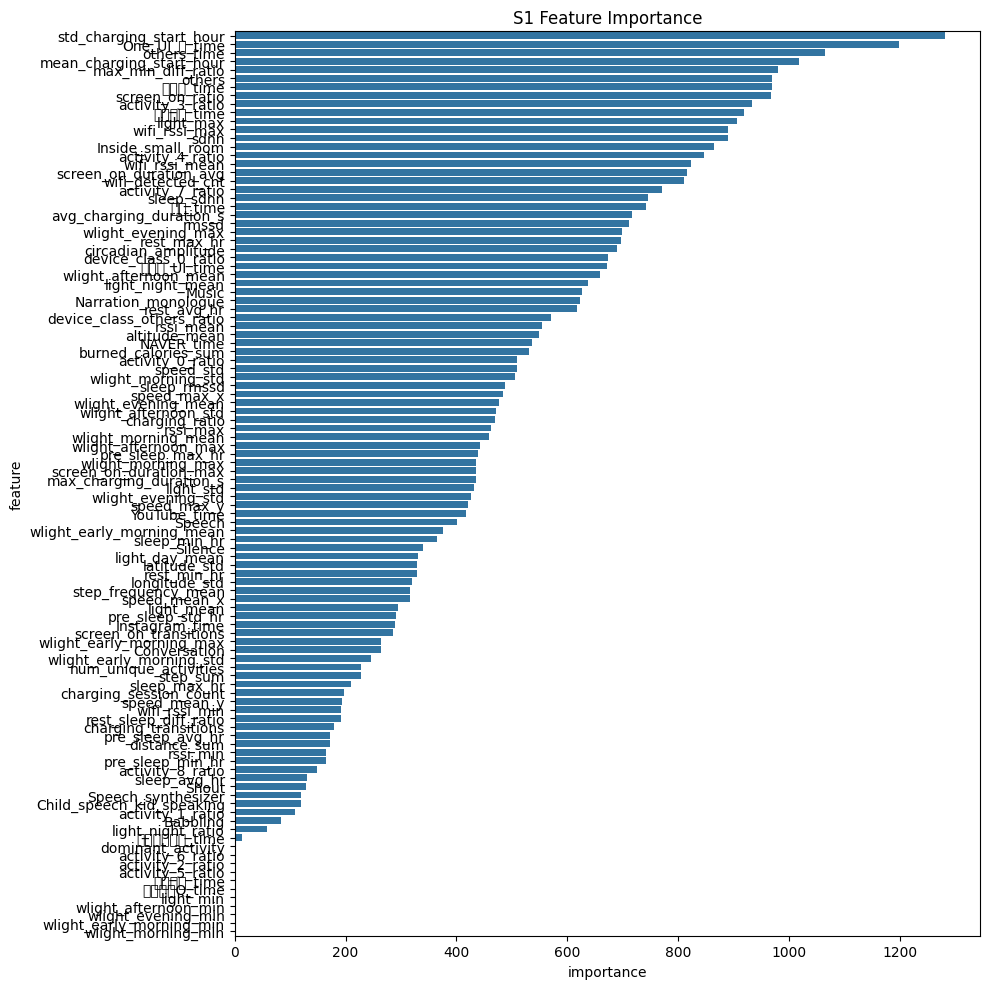

In [35]:
###############-----01-----

import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import matplotlib.pyplot as plt
import seaborn as sns

# ─────────────────────────────────────────
# 1) 타겟 & 피처 준비
# ─────────────────────────────────────────
targets_binary     = ['Q1', 'Q2', 'Q3', 'S2', 'S3']
target_multiclass  = 'S1'

X = train_df.drop(columns=['subject_id','sleep_date','date'] + targets_binary + [target_multiclass])
X.fillna(0, inplace=True)

test_X = test_df.drop(columns=['subject_id','date'])
test_X.fillna(0, inplace=True)

def sanitize_column_names(df):
    df.columns = (
        df.columns
          .str.replace(r"[^\w]", "_", regex=True)
          .str.replace(r"__+", "_", regex=True)
          .str.strip("_")
    )
    return df

X      = sanitize_column_names(X)
test_X = sanitize_column_names(test_X)

# 그룹 정보 및 다중분류 라벨
groups  = train_df['subject_id']
y_multi = train_df[target_multiclass]

# ─────────────────────────────────────────
# 2) Optuna 하이퍼파라미터 탐색 (S1 다중분류)
# ─────────────────────────────────────────
def objective(trial):
    params = {
        'objective': 'multiclass',
        'num_class': y_multi.nunique(),
        'metric':    'multi_logloss',
        'verbosity': -1,
        'random_state': 42,
        'learning_rate':    trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'n_estimators':     trial.suggest_int('n_estimators', 200, 2000),
        'num_leaves':       trial.suggest_int('num_leaves', 16, 256),
        'max_depth':        trial.suggest_int('max_depth', 4, 16),
        'min_child_samples':trial.suggest_int('min_child_samples', 5, 100),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'bagging_freq':     1,
        'lambda_l1':        trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2':        trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
    }

    gkf = GroupKFold(n_splits=5)
    scores = []
    for tr_idx, val_idx in gkf.split(X, y_multi, groups=groups):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y_multi.iloc[tr_idx], y_multi.iloc[val_idx]

        model = LGBMClassifier(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=0)]
        )
        preds = model.predict(X_val)
        scores.append(f1_score(y_val, preds, average='macro'))
    return np.mean(scores)

study = optuna.create_study(direction='maximize', study_name='lgbm_s1_f1')
study.optimize(objective, n_trials=50, timeout=60*30)

print("Best CV F1 (S1):", study.best_value)
print("Best params (S1):", study.best_params)

# ─────────────────────────────────────────
# 3) 최적 파라미터 적용
# ─────────────────────────────────────────
best_params = study.best_params.copy()
best_params.update({
    'objective': 'multiclass',
    'num_class': y_multi.nunique(),
    'metric':    'multi_logloss',
    'verbosity': -1,
    'random_state': 42
})

# ─────────────────────────────────────────
# 이진 분류용 파라미터 재정의
# ─────────────────────────────────────────
binary_params = best_params.copy()

# multiclass 전용 키 제거
binary_params.pop('num_class', None)

# 바이너리 전용 설정
binary_params.update({
    'objective': 'binary',
    'metric':    'binary_logloss',
})

# ─────────────────────────────────────────
# 4) 모델 학습 & 예측
# ─────────────────────────────────────────
binary_preds = {}
for col in targets_binary:
    y_bin = train_df[col]
    clf = LGBMClassifier(**binary_params)
    clf.fit(X, y_bin)
    binary_preds[col] = clf.predict(test_X)

# 다중분류 (S1)
clf_s1 = LGBMClassifier(**best_params)
clf_s1.fit(X, y_multi)
multiclass_pred = clf_s1.predict(test_X)

# ─────────────────────────────────────────
# 5) 피처 중요도 시각화 (S1 기준)
# ─────────────────────────────────────────
feat_imp = pd.DataFrame({
    'feature': X.columns,
    'importance': clf_s1.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=feat_imp)
plt.title('S1 Feature Importance')
plt.tight_layout()
plt.show()


In [36]:
from sklearn.model_selection import cross_validate, GroupKFold
from sklearn.metrics       import make_scorer, f1_score
from lightgbm              import LGBMClassifier

# 3-1) CV 평가용 Classifier & 설정
clf = LGBMClassifier(**best_params)
cv  = GroupKFold(n_splits=5)
scoring = make_scorer(f1_score, average='macro')

# 3-2) cross_validate 실행 (train/validation 모두 계산)
cv_results = cross_validate(
    clf,
    X, y_multi,
    groups=groups,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

# 3-3) Fold별 점수 & 평균·표준편차 출력
train_scores = cv_results['train_score']
val_scores   = cv_results['test_score']

print("Fold별 Train F1 :", train_scores)
print("Fold별 Val   F1 :", val_scores)
print(f"Mean±Std Train F1: {train_scores.mean():.4f} ± {train_scores.std():.4f}")
print(f"Mean±Std Val   F1: {val_scores.mean():.4f} ± {val_scores.std():.4f}")


Fold별 Train F1 : [1. 1. 1. 1. 1.]
Fold별 Val   F1 : [0.32258574 0.25929934 0.3164147  0.27314815 0.33868093]
Mean±Std Train F1: 1.0000 ± 0.0000
Mean±Std Val   F1: 0.3020 ± 0.0304


In [37]:
# sample 기반 제출 포맷 가져오기
submission_final = sample_submission[['subject_id', 'sleep_date', 'lifelog_date']].copy()

# lifelog_date 기준으로 string → date 형식 통일
submission_final['lifelog_date'] = pd.to_datetime(submission_final['lifelog_date']).dt.date

# ID 만들기 (submission에서 예측한 결과와 연결하기 위해)
submission_final['ID'] = submission_final['subject_id'] + '_' + submission_final['lifelog_date'].astype(str)

# 예측 결과 연결할 수 있도록 동일한 순서로 정렬
# 보통 예측 결과는 test_df 기준이므로 정렬 보장되어야 함
assert len(submission_final) == len(multiclass_pred)  # shape 체크

# 다중 분류 예측 붙이기
submission_final['S1'] = multiclass_pred

# 이진 분류 결과 붙이기
for col in ['Q1', 'Q2', 'Q3', 'S2', 'S3']:
    submission_final[col] = binary_preds[col].astype(int)  # 확률 아닌 class 예측

# 최종 제출 형식 정렬
submission_final = submission_final[['subject_id', 'sleep_date', 'lifelog_date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']]

# 저장
submission_final.to_csv("submission_final.csv", index=False)

from google.colab import files
files.download("submission_final.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>